# **Direct Preference Optimization (DPO) Using Hugging Face**

The direct preference optimization (DPO) method comes in place which directly optimizes LLMs based models on user preferences, enhancing their alignment with human expectations.

In [1]:
!pip install torch==2.3.1
!pip install --user trl==0.11.4 # for optimization training
!pip install peft==0.14.0 # for creating LoRA architecture
!pip install matplotlib==3.9.0 
!pip install pandas
!pip install numpy==1.26.0
!pip install --user datasets==3.2.0

  Attempting uninstall: trl
    Found existing installation: trl 0.11.0
    Uninstalling trl-0.11.0:
      Successfully uninstalled trl-0.11.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 7.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Using cached numpy-1.26.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (99 kB)
Using cached numpy-1.26.0-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


In [2]:
!pip install transformers==4.45.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 11.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3━━━━━━━━━━━━━━━━ 1/2 [transformers]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [transformers] [transformers]


In [3]:
##imports
import multiprocessing
import os
import requests
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset

from peft import LoraConfig
from transformers import AutoModelForCausalLM, AutoTokenizer,TrainingArguments, GPT2Tokenizer, set_seed, GenerationConfig
from trl import DPOConfig, DPOTrainer


/Users/ajborbz/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create and configure the model tokenizer

In [4]:

# Load the GPT-2 model
model = AutoModelForCausalLM.from_pretrained("gpt2")

# Load a reference model 
model_ref = AutoModelForCausalLM.from_pretrained("gpt2")

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set the pad token to the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to "right" to fix the overflow issue with FP16 training
tokenizer.padding_side = "right"

# Disable the use of the cache during the model's forward pass
model.config.use_cache = False

### check the model

In [5]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Pre-process the dataset

In [6]:
# Load the dataset from the specified location
ds = load_dataset("BarraHome/ultrafeedback_binarized")

Generating test_gen split: 100%|██████████| 1000/1000 [00:00<00:00, 180470.03 examples/s]


In [7]:
ds.keys()

dict_keys(['train_prefs', 'train_sft', 'test_prefs', 'test_sft', 'train_gen', 'test_gen'])

In [8]:
ds["train_prefs"][0].keys()

dict_keys(['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'])

In [9]:
ds["train_prefs"][0]

{'prompt': 'how can i develop a habit of drawing daily',
 'prompt_id': '086b3e24f29b8956a01059f79c56db35d118a06fb6b844b095737d042795cd43',
 'chosen': [{'content': 'how can i develop a habit of drawing daily',
   'role': 'user'},
  {'content': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: Allocate a specific time of the day to draw. It could be in the morning, afternoon, or evening. Make drawing a part of your daily routine.\n2. Set a specific duration: Determine the amount of time you want to spend on drawing each day. It can be as little as 10 minutes or as long as an hour. Be consistent with the duration to help build the habit.\n3. Start small and simple: Don't try to create a masterpiece every day, start with simple and easy-to-do sketches. Focus on improving yo

In [10]:

for key in ds:
    #cnt = round(ds[key].__len__()*0.05)
    cnt=50
    ds[key] = ds[key].select(range(cnt))

# Define a function to process the data
def process(row):
    # delete unwanted columns
    del row["prompt_id"]
    del row["messages"]
    del row["score_chosen"]
    del row["score_rejected"]
    # retrieve the actual response text
    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]

    return row

# Apply the data processing function to the dataset
ds = ds.map(
    process,
    num_proc=multiprocessing.cpu_count(),
    load_from_cache_file=False,
)

# Split the dataset into training and evaluation sets
train_dataset = ds['train_prefs']
eval_dataset = ds['test_prefs']



Map (num_proc=10): 100%|██████████| 50/50 [00:00<00:00, 480.72 examples/s]


In [11]:
train_dataset[0]

{'prompt': 'how can i develop a habit of drawing daily',
 'chosen': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: Allocate a specific time of the day to draw. It could be in the morning, afternoon, or evening. Make drawing a part of your daily routine.\n2. Set a specific duration: Determine the amount of time you want to spend on drawing each day. It can be as little as 10 minutes or as long as an hour. Be consistent with the duration to help build the habit.\n3. Start small and simple: Don't try to create a masterpiece every day, start with simple and easy-to-do sketches. Focus on improving your skills gradually.\n4. Use a variety of tools and mediums: Experiment with different tools like pencils, pens, markers, and different mediums like paper, canvas, or digital 

In [12]:
# PEFT (Parameter-Efficient Finetuning) configuration
peft_config = LoraConfig(
        # The rank of the low-rank adaptation weights
        r=4,
        # The target modules to apply the low-rank adaptation to
        target_modules=['c_proj','c_attn'],
        # The task type for the low-rank adaptation
        task_type="CAUSAL_LM",
        # The scaling factor for the low-rank adaptation weights
        lora_alpha=8,
        # The dropout probability for the low-rank adaptation weights
        lora_dropout=0.1,
        # The bias mode for the low-rank adaptation
        bias="none",
)

In [13]:
# DPO configuration
from peft import get_peft_model
training_args = DPOConfig(
    # The beta parameter for the DPO loss function
    #beta is the temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5 . 
    beta=0.1,
    # The output directory for the training
    output_dir="dpo",
    # The number of training epochs
    num_train_epochs=5,
    # The batch size per device during training
    per_device_train_batch_size=1,
    # The batch size per device during evaluation
    per_device_eval_batch_size=1,
    # Whether to remove unused columns from the dataset
    remove_unused_columns=False,
    # The number of steps between logging training progress
    logging_steps=10,
    # The number of gradient accumulation steps
    gradient_accumulation_steps=1,
    # The learning rate for the optimization
    learning_rate=1e-4,
    # The evaluation strategy (e.g., after each step or epoch)
    evaluation_strategy="epoch",
    # The number of warmup steps for the learning rate scheduler
    warmup_steps=2,
    # Whether to use 16-bit (float16) precision
    fp16=False,
    # The number of steps between saving checkpoints
    save_steps=500,
    # The maximum number of checkpoints to keep
    #save_total_limit=2,
    # The reporting backend to use (set to 'none' to disable, you can also report to wandb or tensorboard)
    report_to='none'
)

/Users/ajborbz/.pyenv/versions/3.11.9/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
tokenizer.pad_token = tokenizer.eos_token

# Create a DPO trainer
# This trainer will handle the fine-tuning of the model using the DPO technique
trainer = DPOTrainer(
        # The model to be fine-tuned
        model=model,
        # The reference model (not used in this case because LoRA has been used)
        ref_model=None,
        # The DPO training configuration
        args=training_args,
        # The beta parameter for the DPO loss function
       
        # The training dataset
        train_dataset=train_dataset,
        # The evaluation dataset
        eval_dataset=eval_dataset,
        # The tokenizer for the model
        tokenizer=tokenizer,
        # The PEFT (Parallel Efficient Finetuning) configuration
        peft_config=peft_config,
        # The maximum prompt length
        #max_prompt_length=512,
        # The maximum sequence length
        max_length=512,
    )


/Users/ajborbz/.pyenv/versions/3.11.9/lib/python3.11/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in DPOTrainer, please use the DPOConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/Users/ajborbz/.local/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/Users/ajborbz/.local/lib/python3.11/site-packages/trl/trainer/dpo_trainer.py:655: UserWarning: You passed `max_length` to the DPOTrainer, the value you passed will override the one in the `DPOConfig`.
  warnings.warn(
/Users/ajborbz/.local/lib/python3.11/site-packages/trl/trainer/dpo_trainer.py:673: UserWarning: `max_prompt_length` is not set in the DPOConfig's init it will default to `128` by default, but yo

In [15]:
# Start the training process
trainer.train()

  4%|▍         | 10/250 [00:18<04:59,  1.25s/it]

{'loss': 0.6809, 'grad_norm': 17.265296936035156, 'learning_rate': 9.677419354838711e-05, 'rewards/chosen': -0.0045308684930205345, 'rewards/rejected': -0.02962135709822178, 'rewards/accuracies': 0.4000000059604645, 'rewards/margins': 0.02509048581123352, 'logps/rejected': -525.1778564453125, 'logps/chosen': -571.62451171875, 'logits/rejected': -101.85790252685547, 'logits/chosen': -106.02275085449219, 'epoch': 0.2}


  8%|▊         | 20/250 [00:27<03:26,  1.11it/s]

{'loss': 0.8089, 'grad_norm': 3.980689764022827, 'learning_rate': 9.274193548387096e-05, 'rewards/chosen': -0.16527557373046875, 'rewards/rejected': 0.001770591363310814, 'rewards/accuracies': 0.6000000238418579, 'rewards/margins': -0.16704615950584412, 'logps/rejected': -403.49371337890625, 'logps/chosen': -531.5842895507812, 'logits/rejected': -103.57429504394531, 'logits/chosen': -106.26271057128906, 'epoch': 0.4}


 12%|█▏        | 30/250 [00:35<03:14,  1.13it/s]

{'loss': 0.6944, 'grad_norm': 5.287778377532959, 'learning_rate': 8.870967741935484e-05, 'rewards/chosen': 0.004091720562428236, 'rewards/rejected': 0.006524925120174885, 'rewards/accuracies': 0.5, 'rewards/margins': -0.002433204324916005, 'logps/rejected': -365.9629821777344, 'logps/chosen': -466.71722412109375, 'logits/rejected': -106.80622863769531, 'logits/chosen': -107.11924743652344, 'epoch': 0.6}


 16%|█▌        | 40/250 [00:45<03:48,  1.09s/it]

{'loss': 0.7002, 'grad_norm': 9.962821006774902, 'learning_rate': 8.467741935483871e-05, 'rewards/chosen': 0.06705612689256668, 'rewards/rejected': 0.07919532805681229, 'rewards/accuracies': 0.6000000238418579, 'rewards/margins': -0.012139205820858479, 'logps/rejected': -558.9878540039062, 'logps/chosen': -698.1694946289062, 'logits/rejected': -104.8274917602539, 'logits/chosen': -100.77424621582031, 'epoch': 0.8}


 20%|██        | 50/250 [00:53<03:28,  1.04s/it]

{'loss': 0.6869, 'grad_norm': 7.697358131408691, 'learning_rate': 8.064516129032258e-05, 'rewards/chosen': 0.18263283371925354, 'rewards/rejected': 0.14982345700263977, 'rewards/accuracies': 0.4000000059604645, 'rewards/margins': 0.03280936926603317, 'logps/rejected': -584.9808349609375, 'logps/chosen': -534.7027587890625, 'logits/rejected': -107.00467681884766, 'logits/chosen': -97.87918090820312, 'epoch': 1.0}


                                                
 20%|██        | 50/250 [01:32<03:28,  1.04s/it]

{'eval_loss': 0.6769051551818848, 'eval_runtime': 38.7326, 'eval_samples_per_second': 1.291, 'eval_steps_per_second': 1.291, 'eval_rewards/chosen': 0.121212437748909, 'eval_rewards/rejected': 0.07737963646650314, 'eval_rewards/accuracies': 0.5199999809265137, 'eval_rewards/margins': 0.043832797557115555, 'eval_logps/rejected': -527.8206787109375, 'eval_logps/chosen': -536.1962280273438, 'eval_logits/rejected': -103.1875228881836, 'eval_logits/chosen': -103.22306823730469, 'epoch': 1.0}


 24%|██▍       | 60/250 [01:38<03:40,  1.16s/it]

{'loss': 0.5441, 'grad_norm': 4.247293949127197, 'learning_rate': 7.661290322580645e-05, 'rewards/chosen': 0.3865159749984741, 'rewards/rejected': 0.025981903076171875, 'rewards/accuracies': 0.800000011920929, 'rewards/margins': 0.36053404211997986, 'logps/rejected': -554.64697265625, 'logps/chosen': -667.1461181640625, 'logits/rejected': -101.09928894042969, 'logits/chosen': -103.21807861328125, 'epoch': 1.2}


 28%|██▊       | 70/250 [01:44<02:02,  1.47it/s]

{'loss': 0.5162, 'grad_norm': 4.843228816986084, 'learning_rate': 7.258064516129033e-05, 'rewards/chosen': 0.6286168694496155, 'rewards/rejected': 0.14374110102653503, 'rewards/accuracies': 0.8999999761581421, 'rewards/margins': 0.48487573862075806, 'logps/rejected': -488.85882568359375, 'logps/chosen': -676.5802612304688, 'logits/rejected': -99.73616790771484, 'logits/chosen': -96.54483795166016, 'epoch': 1.4}


 32%|███▏      | 80/250 [01:50<01:16,  2.22it/s]

{'loss': 0.6421, 'grad_norm': 8.51209545135498, 'learning_rate': 6.854838709677419e-05, 'rewards/chosen': 0.5024452209472656, 'rewards/rejected': 0.10782929509878159, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': 0.39461594820022583, 'logps/rejected': -713.5711669921875, 'logps/chosen': -620.0317993164062, 'logits/rejected': -106.9891586303711, 'logits/chosen': -101.88932037353516, 'epoch': 1.6}


 36%|███▌      | 90/250 [01:54<01:00,  2.65it/s]

{'loss': 0.6741, 'grad_norm': 2327.728271484375, 'learning_rate': 6.451612903225807e-05, 'rewards/chosen': 0.15327009558677673, 'rewards/rejected': 0.07456226646900177, 'rewards/accuracies': 0.800000011920929, 'rewards/margins': 0.07870785146951675, 'logps/rejected': -223.2626953125, 'logps/chosen': -348.4165344238281, 'logits/rejected': -105.0782241821289, 'logits/chosen': -105.0091781616211, 'epoch': 1.8}


 40%|████      | 100/250 [02:00<01:46,  1.41it/s]

{'loss': 0.5819, 'grad_norm': 4.429114818572998, 'learning_rate': 6.048387096774194e-05, 'rewards/chosen': 0.38102373480796814, 'rewards/rejected': 0.07993423938751221, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': 0.30108949542045593, 'logps/rejected': -456.01995849609375, 'logps/chosen': -470.94451904296875, 'logits/rejected': -103.71173095703125, 'logits/chosen': -104.32010650634766, 'epoch': 2.0}


                                                 
 40%|████      | 100/250 [02:18<01:46,  1.41it/s]

{'eval_loss': 0.675879955291748, 'eval_runtime': 17.3825, 'eval_samples_per_second': 2.876, 'eval_steps_per_second': 2.876, 'eval_rewards/chosen': 0.325842022895813, 'eval_rewards/rejected': 0.1842769980430603, 'eval_rewards/accuracies': 0.5400000214576721, 'eval_rewards/margins': 0.14156503975391388, 'eval_logps/rejected': -526.751708984375, 'eval_logps/chosen': -534.1499633789062, 'eval_logits/rejected': -100.49874114990234, 'eval_logits/chosen': -100.609375, 'epoch': 2.0}


 44%|████▍     | 110/250 [02:22<01:35,  1.47it/s]

{'loss': 0.4624, 'grad_norm': 6050.931640625, 'learning_rate': 5.645161290322582e-05, 'rewards/chosen': 0.8822858929634094, 'rewards/rejected': -0.03524276986718178, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': 0.917528510093689, 'logps/rejected': -270.0076599121094, 'logps/chosen': -446.0860900878906, 'logits/rejected': -99.2984390258789, 'logits/chosen': -103.523193359375, 'epoch': 2.2}


 48%|████▊     | 120/250 [02:28<01:23,  1.56it/s]

{'loss': 0.4076, 'grad_norm': 4.830496311187744, 'learning_rate': 5.241935483870968e-05, 'rewards/chosen': 1.080162763595581, 'rewards/rejected': 0.13757401704788208, 'rewards/accuracies': 0.800000011920929, 'rewards/margins': 0.9425886869430542, 'logps/rejected': -515.6495361328125, 'logps/chosen': -604.4005126953125, 'logits/rejected': -99.19309997558594, 'logits/chosen': -96.44218444824219, 'epoch': 2.4}


 52%|█████▏    | 130/250 [02:33<01:07,  1.78it/s]

{'loss': 0.8476, 'grad_norm': 4.266716003417969, 'learning_rate': 4.8387096774193554e-05, 'rewards/chosen': 0.14761753380298615, 'rewards/rejected': 0.2767096161842346, 'rewards/accuracies': 0.6000000238418579, 'rewards/margins': -0.12909209728240967, 'logps/rejected': -384.1741943359375, 'logps/chosen': -321.66217041015625, 'logits/rejected': -103.56302642822266, 'logits/chosen': -94.74415588378906, 'epoch': 2.6}


 56%|█████▌    | 140/250 [02:39<01:01,  1.78it/s]

{'loss': 0.9654, 'grad_norm': 3.1361310482025146, 'learning_rate': 4.435483870967742e-05, 'rewards/chosen': 0.6032224893569946, 'rewards/rejected': 0.6577669382095337, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': -0.05454451963305473, 'logps/rejected': -611.1104736328125, 'logps/chosen': -628.0567626953125, 'logits/rejected': -97.07010650634766, 'logits/chosen': -98.55879211425781, 'epoch': 2.8}


 60%|██████    | 150/250 [02:45<00:44,  2.27it/s]

{'loss': 0.3246, 'grad_norm': 5224.98193359375, 'learning_rate': 4.032258064516129e-05, 'rewards/chosen': 2.219295024871826, 'rewards/rejected': 0.15901276469230652, 'rewards/accuracies': 1.0, 'rewards/margins': 2.0602822303771973, 'logps/rejected': -647.7800903320312, 'logps/chosen': -754.1065673828125, 'logits/rejected': -96.04419708251953, 'logits/chosen': -97.40699768066406, 'epoch': 3.0}


                                                 
 60%|██████    | 150/250 [03:00<00:44,  2.27it/s]

{'eval_loss': 0.7281240820884705, 'eval_runtime': 15.4193, 'eval_samples_per_second': 3.243, 'eval_steps_per_second': 3.243, 'eval_rewards/chosen': 0.5629247426986694, 'eval_rewards/rejected': 0.3337811529636383, 'eval_rewards/accuracies': 0.5199999809265137, 'eval_rewards/margins': 0.22914360463619232, 'eval_logps/rejected': -525.2566528320312, 'eval_logps/chosen': -531.7791137695312, 'eval_logits/rejected': -96.20954132080078, 'eval_logits/chosen': -96.34758758544922, 'epoch': 3.0}


 64%|██████▍   | 160/250 [03:05<01:00,  1.48it/s]

{'loss': 0.4155, 'grad_norm': 5.1459808349609375, 'learning_rate': 3.6290322580645165e-05, 'rewards/chosen': 0.8586424589157104, 'rewards/rejected': -0.19064892828464508, 'rewards/accuracies': 0.800000011920929, 'rewards/margins': 1.0492914915084839, 'logps/rejected': -362.4395446777344, 'logps/chosen': -514.8309326171875, 'logits/rejected': -100.14535522460938, 'logits/chosen': -92.20953369140625, 'epoch': 3.2}


 68%|██████▊   | 170/250 [03:10<00:33,  2.41it/s]

{'loss': 0.4085, 'grad_norm': 3.1623072624206543, 'learning_rate': 3.2258064516129034e-05, 'rewards/chosen': 2.0032856464385986, 'rewards/rejected': 0.09609753638505936, 'rewards/accuracies': 0.8999999761581421, 'rewards/margins': 1.907188057899475, 'logps/rejected': -438.8282775878906, 'logps/chosen': -489.130859375, 'logits/rejected': -99.10978698730469, 'logits/chosen': -100.75556182861328, 'epoch': 3.4}


 72%|███████▏  | 180/250 [03:15<00:32,  2.14it/s]

{'loss': 0.4517, 'grad_norm': 12380.658203125, 'learning_rate': 2.822580645161291e-05, 'rewards/chosen': 1.9986076354980469, 'rewards/rejected': 0.36752182245254517, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': 1.631085991859436, 'logps/rejected': -507.622802734375, 'logps/chosen': -504.10101318359375, 'logits/rejected': -90.80762481689453, 'logits/chosen': -95.16021728515625, 'epoch': 3.6}


 76%|███████▌  | 190/250 [03:20<00:30,  1.97it/s]

{'loss': 0.8444, 'grad_norm': 2.0166239738464355, 'learning_rate': 2.4193548387096777e-05, 'rewards/chosen': 0.9940754771232605, 'rewards/rejected': 0.7343533039093018, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': 0.25972217321395874, 'logps/rejected': -677.711181640625, 'logps/chosen': -654.1812133789062, 'logits/rejected': -91.58334350585938, 'logits/chosen': -92.47053527832031, 'epoch': 3.8}


 80%|████████  | 200/250 [03:24<00:22,  2.18it/s]

{'loss': 0.6255, 'grad_norm': 44.16078567504883, 'learning_rate': 2.0161290322580645e-05, 'rewards/chosen': 0.6262553334236145, 'rewards/rejected': -0.02257729135453701, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': 0.6488324999809265, 'logps/rejected': -444.23095703125, 'logps/chosen': -576.585205078125, 'logits/rejected': -92.94117736816406, 'logits/chosen': -91.35755157470703, 'epoch': 4.0}


                                                 
 80%|████████  | 200/250 [03:37<00:22,  2.18it/s]

{'eval_loss': 0.776227593421936, 'eval_runtime': 13.1507, 'eval_samples_per_second': 3.802, 'eval_steps_per_second': 3.802, 'eval_rewards/chosen': 0.677553653717041, 'eval_rewards/rejected': 0.41182655096054077, 'eval_rewards/accuracies': 0.5400000214576721, 'eval_rewards/margins': 0.26572707295417786, 'eval_logps/rejected': -524.4761962890625, 'eval_logps/chosen': -530.6327514648438, 'eval_logits/rejected': -92.71642303466797, 'eval_logits/chosen': -92.800537109375, 'epoch': 4.0}


 84%|████████▍ | 210/250 [03:43<00:21,  1.83it/s]

{'loss': 0.2083, 'grad_norm': 2.892122507095337, 'learning_rate': 1.6129032258064517e-05, 'rewards/chosen': 2.9588446617126465, 'rewards/rejected': -0.13755598664283752, 'rewards/accuracies': 1.0, 'rewards/margins': 3.096400499343872, 'logps/rejected': -472.33544921875, 'logps/chosen': -591.3701171875, 'logits/rejected': -92.431884765625, 'logits/chosen': -94.9902572631836, 'epoch': 4.2}


 88%|████████▊ | 220/250 [03:47<00:12,  2.37it/s]

{'loss': 0.398, 'grad_norm': 1.8745920658111572, 'learning_rate': 1.2096774193548388e-05, 'rewards/chosen': 1.038756012916565, 'rewards/rejected': -0.22262270748615265, 'rewards/accuracies': 0.800000011920929, 'rewards/margins': 1.2613786458969116, 'logps/rejected': -376.3970947265625, 'logps/chosen': -449.18212890625, 'logits/rejected': -92.65045928955078, 'logits/chosen': -91.82759094238281, 'epoch': 4.4}


 92%|█████████▏| 230/250 [03:52<00:11,  1.78it/s]

{'loss': 0.5845, 'grad_norm': 12.579294204711914, 'learning_rate': 8.064516129032258e-06, 'rewards/chosen': 1.0154592990875244, 'rewards/rejected': 0.11898133903741837, 'rewards/accuracies': 0.6000000238418579, 'rewards/margins': 0.8964776992797852, 'logps/rejected': -544.7539672851562, 'logps/chosen': -581.7349853515625, 'logits/rejected': -86.79488372802734, 'logits/chosen': -88.29772186279297, 'epoch': 4.6}


 96%|█████████▌| 240/250 [03:56<00:04,  2.44it/s]

{'loss': 0.8651, 'grad_norm': 16002.1748046875, 'learning_rate': 4.032258064516129e-06, 'rewards/chosen': 1.7477893829345703, 'rewards/rejected': 1.0017162561416626, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': 0.7460731267929077, 'logps/rejected': -523.4246826171875, 'logps/chosen': -564.0079345703125, 'logits/rejected': -85.58613586425781, 'logits/chosen': -93.05531311035156, 'epoch': 4.8}


100%|██████████| 250/250 [04:01<00:00,  2.49it/s]

{'loss': 0.5246, 'grad_norm': 15.889613151550293, 'learning_rate': 0.0, 'rewards/chosen': 0.5927814245223999, 'rewards/rejected': 0.01980336755514145, 'rewards/accuracies': 0.699999988079071, 'rewards/margins': 0.5729780197143555, 'logps/rejected': -515.9656982421875, 'logps/chosen': -543.8064575195312, 'logits/rejected': -106.28206634521484, 'logits/chosen': -93.64371490478516, 'epoch': 5.0}


                                                 
100%|██████████| 250/250 [04:16<00:00,  1.03s/it]

{'eval_loss': 0.7930124402046204, 'eval_runtime': 14.1957, 'eval_samples_per_second': 3.522, 'eval_steps_per_second': 3.522, 'eval_rewards/chosen': 0.7092416882514954, 'eval_rewards/rejected': 0.4399928152561188, 'eval_rewards/accuracies': 0.5199999809265137, 'eval_rewards/margins': 0.2692488431930542, 'eval_logps/rejected': -524.1945190429688, 'eval_logps/chosen': -530.31591796875, 'eval_logits/rejected': -91.81561279296875, 'eval_logits/chosen': -91.88536834716797, 'epoch': 5.0}
{'train_runtime': 256.5512, 'train_samples_per_second': 0.974, 'train_steps_per_second': 0.974, 'train_loss': 0.5945255393981934, 'epoch': 5.0}


TrainOutput(global_step=250, training_loss=0.5945255393981934, metrics={'train_runtime': 256.5512, 'train_samples_per_second': 0.974, 'train_steps_per_second': 0.974, 'total_flos': 0.0, 'train_loss': 0.5945255393981934, 'epoch': 5.0})

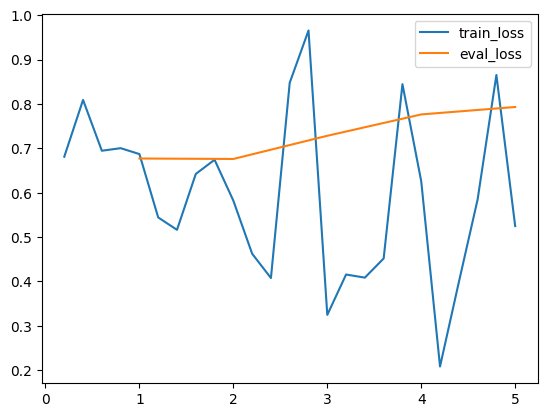

In [16]:
# Retrieve log_history and save it to a dataframe
log = pd.DataFrame(trainer.state.log_history)
log_t = log[log['loss'].notna()]
log_e = log[log['eval_loss'].notna()]

# Plot train and evaluation losses
plt.plot(log_t["epoch"], log_t["loss"], label = "train_loss") 
plt.plot(log_e["epoch"], log_e["eval_loss"], label = "eval_loss") 
plt.legend() 
plt.show()

In [17]:
# Load the trained DPO model you just trained
dpo_model = AutoModelForCausalLM.from_pretrained('./dpo/checkpoint-250')


In [18]:
# Define the URL and the filename
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YIDeT3qihEpWChdXN_RmTg/DPO-tar.gz'
filename = './DPO.tar'

# Download the file
response = requests.get(url)

# Save the file locally
with open(filename, 'wb') as f:
    f.write(response.content)

# Extract the tar file
if tarfile.is_tarfile(filename):
    with tarfile.open(filename, 'r') as tar:
        tar.extractall()
        print("Files extracted:", tar.getnames())
else:
    print("The adownloaded file is not a tar file.")

Files extracted: ['DPO', 'DPO/adapter_config.json', 'DPO/tokenizer_config.json', 'DPO/merges.txt', 'DPO/adapter_model.safetensors', 'DPO/special_tokens_map.json', 'DPO/training_args.bin', 'DPO/README.md', 'DPO/vocab.json']


In [19]:
# Load the trained DPO model tiy just trained
dpo_model = AutoModelForCausalLM.from_pretrained('./DPO')


In [20]:
# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [21]:
# Set a seed for reproducibility
set_seed(42)


# Define the generation configuration for the DPO model
# This sets the parameters for text generation
generation_config = GenerationConfig(
        # Use sampling to generate diverse text
        do_sample=True,
        # Top-k sampling parameter
        top_k=1,
        # Temperature parameter to control the randomness of the generated text
        temperature=0.1,
        # Maximum number of new tokens to generate
        max_new_tokens=25,
        # Use the end-of-sequence token as the padding token
        pad_token_id=tokenizer.eos_token_id
    )

# Define the input prompt for text generation
PROMPT = "Is a higher octane gasoline better for your car?"
# Encode the prompt using the tokenizer
inputs = tokenizer(PROMPT, return_tensors='pt')

# Generate text using the DPO model
outputs = dpo_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text and print it
print("DPO response:\t",tokenizer.decode(outputs[0], skip_special_tokens=True))

# Load the pre-trained GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained('gpt2')
# Generate text using the GPT-2 model
outputs = gpt2_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text and print it
print("\nGPT2 response:\t",tokenizer.decode(outputs[0], skip_special_tokens=True))

: 